# Paquetes

In [1]:
#---------------------------
#--- Paquetes
#---------------------------
'''Permite buscar y recuperar una lista de nombres de archivos que coinciden con un patrón específico de nombre
de archivo en un directorio o en una jerarquía de directorios.'''
import glob #Búsqueda de archivos
import os #Interacción con el sistema operativo
from io import StringIO
import contextlib
import re


import numpy as np #Operaciones numéricas y arreglos
import pandas as pd #Manipulación y análisis de datos
from datetime import datetime, timedelta #Manejo de fechas y horas
import matplotlib.pyplot as plt #Visualización de datos


import seaborn as sns #Visualización estadística
from statsmodels.tsa.stattools import adfuller# Análisis econométrico y series temporales
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression #Modelos de regresión lineal



# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax


/home/sebastian/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# Historical Sales

In [3]:
#-----------------------------
#--- Sales
#----------------------------
ruta=r'/home/sebastian/Documentos/programas/Forescast Work/Sales_History.csv'

def historical_sales(ruta):
    '''lectura del csv con la inf de venta historica:  este archivo csv es el resultado de unificar todos los xlsx de sharepoint,
      filtrando las columnas de interes para el modelo
    
    Arg: ruta con la ubicacion del archivo csv con la informacion historica de venta
    
    return: dataframe(df_SalesAndProduct) agrupando la venta mensual, organizada por data,country y brand
            y filtrando los valores positivos para realizar un pronostico de venta bruta
    '''

    df_sales_and_product=pd.read_csv(ruta,index_col=None, header=0,dtype=str)

    ''' 
    Date en formato adecuado
    Elimina espacios en los nombres del col
    Se ordena por Date Country Code Brand
    '''
    df_sales_and_product['Date']=pd.to_datetime(df_sales_and_product['Date'],format='%Y-%m-%d')
    for col in df_sales_and_product.columns:
        df_sales_and_product.rename(columns={col: col.strip()}, inplace=True)

    df_sales_and_product = df_sales_and_product.sort_values(by=['Date', 'Country Code', 'Brand'], ascending=[True, False, False])
    df_sales_and_product['Total Sales']=pd.to_numeric(df_sales_and_product['Total Sales'])
    df_sales_and_product=df_sales_and_product[df_sales_and_product['Total Sales']>0]

    return df_sales_and_product


In [4]:
df_sales_and_product=historical_sales(ruta)

In [5]:
df_sales_and_product['c']

,Fiscal Year,Fiscal Period,Country Code,Sold-To Customer Code,Country Material,Total Sales,Total Cost,Units Sold,SKU,SKU Base,...,Brand,GPP Division Code,GPP Division Reclasif,GPP Category Reclasif,GPP Portfolio,SBU,Super SBU,GPP SBU,GPP SBU Description,Date
608742,2019,Jan,Stanley Uruguay,U1/1262120,11-325T,176.0,65,60,11-325T,11-325T,...,Stanley,1,HAND TOOLS (CHT),KNIFE BLADES,SNAP-OFF BLADES,HTS,HTAS,CHT,CONSTRUCTION HAND TOOLS,2019-01-01
608743,2019,Jan,Stanley Uruguay,U1/1262120,28-510,984.0,738,600,28-510,28-510,...,Stanley,1,HAND TOOLS (CHT),KNIFE BLADES,SPECIALTY BLADES,HTS,HTAS,CHT,CONSTRUCTION HAND TOOLS,2019-01-01
608744,2019,Jan,Stanley Uruguay,U1/1262120,11-987,205.0,100,500,11-987,11-987,...,Stanley,1,HAND TOOLS (CHT),KNIFE BLADES,TK BLADES,HTS,HTAS,CHT,CONSTRUCTION HAND TOOLS,2019-01-01
608745,2019,Jan,Stanley Uruguay,U1/1262120,16-227,58.0,30,48,16-227,16-227,...,Stanley,1,HAND TOOLS (CHT),OTHER DEMO,PUNCHES,HTS,HTAS,CHT,CONSTRUCTION HAND TOOLS,2019-01-01
608746,2019,Jan,Stanley Uruguay,U1/1262120,16-288,95.0,34,36,16-288,16-288,...,Stanley,1,HAND TOOLS (CHT),OTHER DEMO,COLD CHISELS,HTS,HTAS,CHT,CONSTRUCTION HAND TOOLS,2019-01-01


# Devolucion

In [10]:
df_sales_and_product=historical_sales(ruta)
def devolucion(df_sales_and_product,año):

    '''Se analiza el % de registros que corresponden a devoluciones,
      para ver su factibilidad de ser imputados de las series'''


    #df_SalesAndProduct=HistoricalSales(ruta)
    df_año = df_sales_and_product[['Date', 'Total Sales']][df_sales_and_product['Date'].dt.year == año]

    # Calcular estadísticas en una sola pasada
    num_reg = len(df_año)
    num_devoluciones = len(df_año[df_año['Total Sales'] < 0])
    venta = df_año['Total Sales'].sum()
    venta_devolucion = df_año[df_año['Total Sales'] < 0]['Total Sales'].sum()
    venta_NoDevolucion = venta - venta_devolucion

    # Imprimir resultados
    print(f'total registros {año}: {num_reg}')
    print(f'num devoluciones {año}: {num_devoluciones}')
    print(f'% devoluciones: {num_devoluciones/num_reg:.3%}')
    print(f'venta total año {año}: {venta}')
    print(f'venta con devoluciones {año}: {venta_devolucion}')
    print(f'venta sin devoluciones {año}: {venta_NoDevolucion}')
    print(f'%venta devolucion: {venta_devolucion/venta:.3%}')
    print(f'%venta sin devolucion: {venta_NoDevolucion/venta:.3%}')

    df_SalesInf=df_sales_and_product[['Date','Total Sales']]
    num_reg=len(df_SalesInf)
    num_dev=len(df_SalesInf[df_SalesInf['Total Sales']<0])
    venta=df_SalesInf['Total Sales'].sum()
    venta_Nodevolucion=df_SalesInf[df_SalesInf['Total Sales'] >= 0]['Total Sales'].sum()
    venta_devolucin=venta-venta_Nodevolucion
    print("*------------------------\n")
    print(f'num registros: {num_reg}')
    print(f'num dev:{num_dev}')
    print(f'venta total: {venta}')
    print(f'% dev:{num_dev/num_reg:.3%}')
    print(f'% No dev:{(num_reg-num_dev)/num_reg:.3%}')
    print(f'venta sin devolucion: {venta_Nodevolucion}')
    print(f'venta devolucion: {venta_devolucin}')
    print(f'% venta sin devolucion: {venta_Nodevolucion/venta:.3%}')
    print(f'%venta con devolucion:{venta_devolucin/venta:.3%}')    

In [11]:
devolucion(df_sales_and_product,2024)

total registros 2024: 2024066
num devoluciones 2024: 0
% devoluciones: 0.000%
venta total año 2024: 753852140.2500002
venta con devoluciones 2024: 0.0
venta sin devoluciones 2024: 753852140.2500002
%venta devolucion: 0.000%
%venta sin devolucion: 100.000%
*------------------------

num registros: 6346147
num dev:0
venta total: 2490588689.6899996
% dev:0.000%
% No dev:100.000%
venta sin devolucion: 2490588689.6899996
venta devolucion: 0.0
% venta sin devolucion: 100.000%
%venta con devolucion:0.000%


# Sales Sharepoint

In [ ]:
'''se leen todos los xlsx de sharepoint, se unifican en un solo df_sales, 
se lee el xlsx de master products
se cruza df_sales con df_products para obtener la clasificacion de los sku con venta'''


#--------------------
# --- SALES 
#--------------------

'''Ruta donde se encuentre la inf de venta'''
def sales_sharepoint():
    paht_data_historica=r'C:\Users\SSN0609\OneDrive - Stanley Black & Decker\Dashboard Marketing\Sales'
    #Crea una lst con la ubicacion de los archivos
    all_files_sales = glob.glob(paht_data_historica + "/*Sales*.xlsx")
    #Filtra los files que son de venta
    filtered_files_sales = [file for file in all_files_sales if "path" not in file]

    lst_sales=[]
    '''Recorre la lista de ubicaciones y lee el xlsx'''
    for filename in filtered_files_sales:
        df = pd.read_excel(filename, index_col=None, header=0,dtype=str)
        lst_sales.append(df)
    len(lst_sales)

    '''Concatena la info de lst_sales(col: inf xlsx) de manera vertical'''
    df_sales= pd.concat(lst_sales,axis=0,ignore_index=True)

    #--------------------
    # --- PRODUCTS 
    #--------------------
    paht_data_product=r'C:\Users\SSN0609\OneDrive - Stanley Black & Decker\Master Data\Master Data Products Reclasif.xlsx'
    df_products=pd.read_excel(paht_data_product,index_col=None,header=0,dtype=str)

#-------------------------------
# --- Eleccion Columnas
#-------------------------------

    Columns_products=['SKU', 'SKU Base', 'SKU Description', 'Brand ', 'GPP Division Code',
       'GPP Division Reclasif', 'GPP Category Reclasif', 'GPP Portfolio ',
       'SBU', 'Super SBU', 'GPP SBU', 'GPP SBU Description']
    df_products=df_products[Columns_products]

    columns_sales=['Fiscal Year', 'Fiscal Period', 'Country Code', 
       'Sold-To Customer Code','Country Material', 'Total Sales', 'Total Cost', 'Units Sold']
    df_sales=df_sales[columns_sales]

    #-----------------------------
    #--- Merge
    #-----------------------------

    df_SalesAndProduct=pd.merge(
    df_sales,df_products,how='left',left_on='Country Material',right_on='SKU'
    )

    print(f'len(df_sales): {len(df_sales)}')
    print(f'len(df_salesProdu): {len(df_SalesAndProduct)}')

    #-------------------------------
    #---- Date
    #-------------------------------
    dict_month={
        'jan':'01',
        'feb':'02',
        'mar':'03',
        'apr':'04',
        'may':'05',
        'jun':'06',
        'jul':'07',
        'aug':'08',
        'sep':'09',
        'oct':'10',
        'nov':'11',
        'dec':'12',
        '1':'01'
    }
    def mes(row):
        month = row['Fiscal Period'].lower()
        month_num = dict_month[month]
        year = row['Fiscal Year']
        date_str = month_num + '-' + year
        return date_str

    df_SalesAndProduct['Date']=df_SalesAndProduct.apply(mes,axis=1) 
    df_SalesAndProduct['Date']=pd.to_datetime(df_SalesAndProduct['Date'],format='%m-%Y')
    df_SalesAndProduct.head()

    for col in df_SalesAndProduct.columns:
        df_SalesAndProduct.rename(columns={col: col.strip()}, inplace=True)


In [ ]:
'''Evaluación del Enfoque y Sugerencias

    Función de Filtrado para Generar Series de Tiempo:
        Comentario: Crear una función que permita generar series de tiempo para un parámetro específico es una excelente idea. Esto te permitirá ver la evolución de las ventas desde perspectivas clave como marca, país o SBU, sin tener que filtrar manualmente.
        Sugerencia de Mejora: Podrías optimizar la función para permitir múltiples filtros, por ejemplo, que acepte un diccionario con varias condiciones ({"brand": "dewalt", "country": "US"}) para flexibilizar los análisis.
        Bonus: Agregar visualizaciones automáticas dentro de la función, como gráficos de líneas, descomposiciones de tendencia, o correlogramas, te dará una visión rápida del comportamiento de cada serie.

    Función para Extraer Métricas Clave de la Serie de Tiempo:
        Comentario: La función que describe los valores importantes (como tendencia, estacionalidad, varianza, autocorrelación, etc.) es fundamental para seleccionar el modelo adecuado.
        Sugerencia de Mejora: Además de devolver métricas clave, podrías considerar agregar un análisis exploratorio automatizado que incluya pruebas estadísticas, como el test de Dickey-Fuller para estacionalidad, y métricas de variabilidad estacional para facilitar la comparación de series entre categorías.
        Bonus: Incluir una clasificación preliminar en función de estas métricas para sugerir directamente un modelo (por ejemplo, si la estacionalidad es fuerte, sugerir SARIMA).

    Función de Modelado Basado en Métricas de la Serie de Tiempo:
        Comentario: Automatizar el ajuste del modelo con base en las características de cada serie de tiempo es un excelente enfoque.
        Sugerencia de Mejora: Considera que, además de seleccionar un modelo, podrías usar una estructura de prueba de múltiples modelos (modelo base + modelo estacional) en paralelo y luego elegir el modelo con menor error de validación.
        Bonus: Además de SARIMA o Prophet, podrías incluir modelos alternativos como TBATS o modelos híbridos (SARIMA + XGBoost) en función de las características, especialmente si tienes datos altamente no lineales.

    Función para Almacenar Predicciones en un DataFrame de Resultados:
        Comentario: La idea de almacenar las predicciones de cada serie de tiempo es excelente para poder consultar los resultados de manera centralizada.
        Sugerencia de Mejora: Podrías organizar el DataFrame para tener un índice multinivel con parámetros como Fiscal Period, Country, Brand, SBU, etc., lo que permitirá filtrar y resumir los resultados fácilmente.
        Bonus: Añadir una columna que indique el error de predicción del modelo para cada serie en el DataFrame de resultados, lo cual permitirá monitorear la precisión de los modelos en el tiempo.

    Función para Generar Matrices Estructuradas (por período fiscal, país, marca, etc.):
        Comentario: Generar matrices estructuradas por características es útil para visualizar los patrones de ventas y, potencialmente, crear correlaciones o relaciones entre variables.
        Sugerencia de Mejora: Asegúrate de que las matrices de datos tengan una estructura consistente (llenando los datos faltantes si es necesario) y considera una agregación preliminar en cada período. Podrías también aprovechar estas matrices para detectar correlaciones interanuales o estacionales entre países y marcas.
        Bonus: En lugar de solo generar la matriz de datos, podrías considerar crear matrices de coeficientes de correlación dinámicas que puedan usarse como input para ajustar modelos combinados.

    Función para el Análisis de Correlación entre Variables:
        Comentario: Evaluar la correlación entre las variables y promediar modelos para las variables altamente correlacionadas es una estrategia sólida para evitar duplicidad en los resultados.
        Sugerencia de Mejora: Podrías definir un umbral de correlación para decidir qué variables se consideran "altamente correlacionadas" y asegurarte de aplicar el promedio de modelos solo en aquellas variables donde la correlación supera este umbral.
        Bonus: En lugar de promediar modelos, podrías optar por modelos de ensamble (ensemble models) donde los modelos de las variables correlacionadas aporten predicciones ponderadas, maximizando la precisión para categorías similares.
'''


# Generar y estacionarizar serie tiempo

In [12]:
#---------------------------------------
#---- Creacion series de tiempo
#---------------------------------------


def time_serie(df, filtros):
    """
    Filtra los datos de ventas según los filtros especificados y devuelve una serie de tiempo.
    Args:
        df (pd.DataFrame): DataFrame con datos de ventas.
        filtros (dict): Diccionario de condiciones para filtrar.
    Returns:
        pd.Series: Serie de tiempo de ventas filtrada.
    """
    for clave, valor in filtros.items():
        df = df[df[clave] == valor]
        
    df = df.groupby(df['Date'].dt.to_period('M'))['Total Sales'].sum().reset_index()
    df['Date'] = df['Date'].dt.to_timestamp()
    serie = df.set_index('Date')['Total Sales']
    serie = serie.asfreq('MS')
    seriesSales=serie.copy()
    return serie, seriesSales

#==============================================
# --- Estacionarizacion series
#=============================================     

def seasonalize_series(serie):
    '''
    Estacionariza la serie de entrada para eliminar tendencias mediante diferenciaciones sucesivas 
    hasta que pase la prueba de ADF o se alcancen las restricciones definidas.

    Args:
        serie (pd.Series): Serie temporal a estacionarizar.
        max_diff (int): Máximo número de diferenciaciones permitidas (default=12).
        min_observations (int): Mínima cantidad de observaciones requeridas después de diferenciar (default=24).
        p_threshold (float): Umbral para el p-valor de la prueba ADF (default=0.05).

    Returns:
        pd.Series: Serie estacionaria con p-valor (ADF) < p_threshold, o la serie diferenciada al máximo permitido.
    '''
    diff_order = 0  # Contador de diferenciaciones
    min_observations= len(serie)-24
    max_diff= len(serie)-24
    p_threshold=0.05
    
    while diff_order < max_diff:
        # Prueba de Dickey-Fuller aumentada
        p_value = adfuller(serie)[1]
        if p_value <= p_threshold:
            # La serie ya es estacionaria
            return serie
        
        # Aplicar diferenciación
        serie = serie.diff().dropna()
        diff_order += 1
        
        # Detener si no quedan suficientes observaciones
        if len(serie) < min_observations:
            print(f"Insuficientes observaciones tras {diff_order} diferenciaciones.")
            break
    
    # Devuelve la serie diferenciada o en su mejor estado
    print(f"Máximo de diferenciaciones alcanzado: {diff_order}")
    return serie

In [14]:
filtros={
'Brand':[''],
'Country Code':[''],
'GPP Division Code':[]

}
serie,serieSales=time_serie(df_sales_and_product,{'Country Code':'Mexico'})
serie=seasonalize_series(serie)
serie.head()

Date
2022-05-01   -9113075.39
2022-06-01    7978888.19
2022-07-01   -5655122.26
2022-08-01    6168840.82
2022-09-01   -6494299.45
Freq: MS, Name: Total Sales, dtype: float64

# Extraer metricas serie

In [17]:

def time_series_metrics(serie):
    descomposicionAdd = sm.tsa.seasonal_decompose(serie, model='additive', period=12)
   # log_ventas = np.log(serie["Total Sales"])
    descomposicionMul = sm.tsa.seasonal_decompose(serie, model='additive', period=12)
    
    serie_estacional=seasonalize_series(serie)
    if len(serie_estacional) < 12:
        descomposicionSer_Est_Add = sm.tsa.seasonal_decompose(serie_estacional, model='additive')  # Handle very short series
    else:
        descomposicionSer_Est_Add = sm.tsa.seasonal_decompose(serie_estacional, model='additive',period=12)


    pvalue_serie_original = "no es" if sm.tsa.adfuller(serie)[1] < 0.05 else "es"
    pvalue_serie_estacionarizada= "si paso la prueba ADF" if sm.tsa.adfuller(serie_estacional)[1] < 0.05 else "No paso la prueba ADF"
    print(f"La serie original {pvalue_serie_original} estacionaria.")
    print(f'la serie estacionaria {pvalue_serie_estacionarizada}')
    
    return {
        "Mod Add tendencia": descomposicionAdd.trend.mean(),
        "Mod Add estacionalidad": descomposicionAdd.seasonal.mean(),
        "Mod Add ruido": descomposicionAdd.resid.mean(),
        "Mod Mul tendencia": descomposicionMul.trend.mean(),
        "Mod Mul estacionalidad": descomposicionMul.seasonal.mean(),
        "Mod Mul ruido": descomposicionMul.resid.mean(),
        
        "ADF Test": sm.tsa.adfuller(serie)[1], 

        "Mod Estacional Add tendencia": descomposicionSer_Est_Add.trend.mean(),
        "Mod Estacional Add estacionalidad": descomposicionSer_Est_Add.seasonal.mean(),
        "Mod Estacional Add ruido": descomposicionSer_Est_Add.resid.mean(),
        
        "ADF Test Estacional": sm.tsa.adfuller(serie_estacional)[1],
        
          
          # p-value
    }



In [18]:
time_series_metrics(serie)

La serie original no es estacionaria.
la serie estacionaria si paso la prueba ADF


{'Mod Add tendencia': 4426.385231481501,
 'Mod Add estacionalidad': -24644.546059027834,
 'Mod Add ruido': -511748.1492187505,
 'Mod Mul tendencia': 4426.385231481501,
 'Mod Mul estacionalidad': -24644.546059027834,
 'Mod Mul ruido': -511748.1492187505,
 'ADF Test': 7.294660927455589e-21,
 'Mod Estacional Add tendencia': 4426.385231481501,
 'Mod Estacional Add estacionalidad': -24644.546059027834,
 'Mod Estacional Add ruido': -511748.1492187505,
 'ADF Test Estacional': 7.294660927455589e-21}

# Graficas

In [ ]:
def graph_box(serie):
    # Create a boxplot and extract outlier information
    plt.figure(figsize=(8, 6))
    plt.boxplot(serie)
    plt.title('Boxplot de Ventas Mensuales')
    plt.ylabel('Ventas')
    plt.show()

    # Calculate quartiles and IQR
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = serie[(serie < lower_bound) | (serie > upper_bound)]

    print("Valores Atípicos (Outliers):\n")
    print(outliers)
    print("Se ejecuto correctamente: graph_box")

In [ ]:


def graph_tendence(serie):
    '''Realiza regresion lineal para el pronostico de la tendencia de la serie sin estacionalizar y estacionalizada '''
    
    ''' Serie estacionalizada     
     Crear índices numéricos para ajustar el modelo'''

    X1 = np.arange(len(serie)).reshape(-1, 1)  # Índices de tiempo como variable independiente
    y1 = serie.values.reshape(-1, 1)           # Ventas totales como variable dependiente
    model_serie_orginal = LinearRegression().fit(X1,y1)       # -> Ajustar el modelo lineal 
    trend1 = model_serie_orginal.predict(X1)                  # Predicción de la tendencia

    ''' Serie estacionalizada     '''

    serie_estacionalizada=seasonalize_series(serie)            #-> estacionariza la serie
    X2  = np.arange(len(serie_estacionalizada)).reshape(-1, 1)    # Índices de tiempo como variable independiente
    y2 = serie_estacionalizada.values.reshape(-1, 1)              # Ventas totales como variable dependiente
    model_serie_estacional = LinearRegression().fit(X2,y2)                          # Ajustar el modelo lineal
    trend2 = model_serie_estacional.predict(X2)                                     # Predicción de la tendencia 




    # Crear una figura con dos subplots en una columna
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))  # Ajusta el tamaño según tus necesidades

    # Primer subplot: Serie original y tendencia sin estacionalidad
    axs[0].plot(serie.values, label="Serie Original", alpha=0.5)
    axs[0].plot(trend1, label="Tendencia Lineal", color="green", linewidth=2)
    axs[0].set_title("Serie de Tiempo con Tendencia Lineal Ajustada (Sin Estacionalidad)")
    axs[0].set_xlabel("Fecha")
    axs[0].set_ylabel("Ventas Totales")
    axs[0].legend()
    axs[0].grid()

    # Segundo subplot: Serie diferenciada y tendencia
    axs[1].plot(serie_estacionalizada.values, label="Serie Diferenciada", alpha=0.5)
    axs[1].plot(trend2, label="Tendencia Lineal", color="green", linewidth=2)
    axs[1].set_title("Serie de Tiempo Diferenciada con Tendencia Lineal Ajustada")
    axs[1].set_xlabel("Fecha")
    axs[1].set_ylabel("Ventas Totales")
    axs[1].legend()
    axs[1].grid()


    # Coeficiente de la tendencia
    coef_tendencia_serie_original = model_serie_orginal.coef_[0][0]
    print(f"Pendiente de la tendencia: {coef_tendencia_serie_original:.2f}")

    coef_tendencia_serie_estacional = model_serie_estacional.coef_[0][0]
    print(f"Pendiente de la tendencia: {coef_tendencia_serie_estacional:.2f}")
    print("Se ejecuto correctamente: graph_tendence")

Pendiente de la tendencia: 109230.96
Pendiente de la tendencia: 109230.96


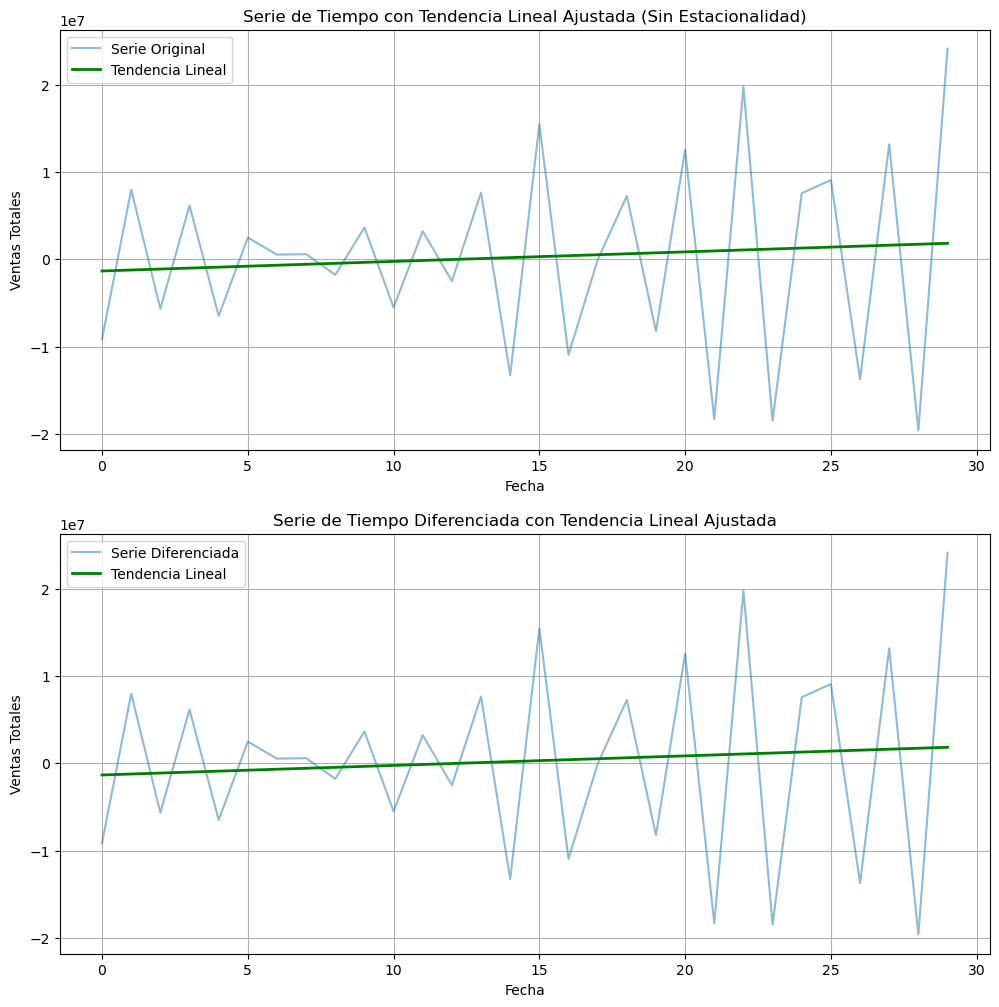

In [21]:
graph_tendence(serie)

In [ ]:
def graph_line(serie):
    num_reg=int(len(serie)*0.5)
    data_train=serie[:num_reg]
    data_test=serie[num_reg-1:]

     #Serie estacionalizada
    serie_estacional=seasonalize_series(serie)
    num_reg2=int(len(serie_estacional)*0.5)
    data_train2=serie_estacional[:num_reg2]
    data_test2=serie_estacional[num_reg2-1:]

    
    fig, ax = plt.subplots(figsize=(7, 3))
    data_train.plot(ax=ax, label='train', marker='o')  # Agregamos marker='o'
    data_test.plot(ax=ax, label='test', marker='o')  # Agregamos marker='o'
    ax.set_title('Serie original')
    ax.legend()

    fig, ax = plt.subplots(figsize=(7, 3))
    data_train2.plot(ax=ax, label='train', marker='o')  # Agregamos marker='o'
    data_test2.plot(ax=ax, label='test', marker='o')  # Agregamos marker='o'
    ax.set_title('Serie estacionariazada')
    ax.legend()

    plt.show()
    print("Se ejecuto correctamente: graph_line")

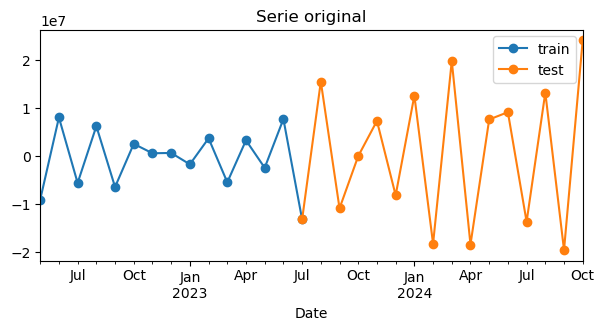

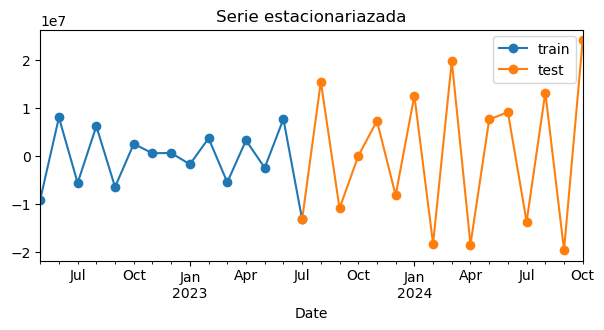

In [23]:
graph_line(serie)

# Data model

In [ ]:
def data_model(serie):
    ''' 
    Segmenta una serie en conjuntos de entrenamiento, validación y prueba, y genera versiones estacionalizadas.

    Args: 
        serie (pd.Series): Serie temporal a segmentar.
    
    Returns:
        tuple: Conjuntos originales y estacionalizados (train, validation, test).
    '''
    num_reg_train=int(len(serie)*0.7)
    num_reg_validacion=int(len(serie)*0.15)
    num_reg_test=int(len(serie)*0.15)

    data_train_orginal=serie[:num_reg_train]
    data_validation_orginal=serie[num_reg_train:num_reg_validacion+num_reg_validacion]
    data_test_orginal=serie[num_reg_test:]

    serie_estacionalizada=seasonalize_series(serie)
    data_train_estacionalizado=serie_estacionalizada[:num_reg_train]
    data_validation_estacionalizado=serie_estacionalizada[num_reg_train:num_reg_validacion+num_reg_validacion]
    data_test_estacionalizado=serie_estacionalizada[num_reg_test:]
    print("Se ejecuto correctamente: data_model")
    return data_train_orginal, data_validation_orginal, data_test_orginal, \
           data_train_estacionalizado, data_validation_estacionalizado, data_test_estacionalizado



In [25]:
data_train_orginal, data_validation_orginal, data_test_orginal, \
           data_train_estacionalizado, data_validation_estacionalizado, data_test_estacionalizado=data_model(serie)

# Best parameters autoarima

In [31]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def best_parameters_auto_arima(serie,
                              data_train_orginal, data_train_estacionalizado):
    
    ''' Recibe una serie, realiza un proceso autoarima para obtener los mejores parametros para:p,d,q,P,D,Q,s
     con base en estos valores establece los rangos que seran usados en la optimizacion de hiperparametros por medio de 
     gridsearch

    Parámetros:
        serie (pd.Series): Serie temporal a analizar.

    Retorna:
        tuple: Rangos para los parámetros p, d, q, P, D, Q y s.
       '''
    
    #Identifica si se esta trabajando con la serie original o la estacionarizada, con base en esto elige el conjunto train
    #con el cual entrenar el modelo autorima

    if len(serie)<len(serieSales):
        data_train=data_train_estacionalizado
    else:
        data_train=data_train_orginal
    
    # Dividir la serie en conjuntos de entrenamiento, validación y prueba
    #train_data, val_data, test_data, train_data_est, val_data_est, test_data_est = Data_Model(serie)

    # Ignorar advertencias para mantener limpio el output
    warnings.filterwarnings("ignore")

    #Realizar autoarima
    auto_model = auto_arima(data_train,
                        seasonal=True,
                        m=12,  # Periodo estacional
                        trace=True,  # Muestra el progreso
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

# Obtén los parámetros recomendados
    best_params = auto_model.get_params()['order']
    best_seasonal_params = auto_model.get_params()['seasonal_order']

    print(f"Parámetros recomendados por AutoARIMA: {best_params}, {best_seasonal_params}")

    # Define rangos reducidos basados en AutoARIMA
    p_range = range(max(0, best_params[0] - 1), best_params[0] + 2)
    d_range = [best_params[1]]  # Usualmente no necesitas variar mucho `d`
    q_range = range(max(0, best_params[2] - 1), best_params[2] + 2)

    P_range = range(max(0, best_seasonal_params[0] - 1), best_seasonal_params[0] + 2)
    D_range = [best_seasonal_params[1]]  # Similar a `d`, no suele variar mucho
    Q_range = range(max(0, best_seasonal_params[2] - 1), best_seasonal_params[2] + 2)
    s = [best_seasonal_params[3]]  # Período fijo

    print(f'p_range: {p_range}')
    print(f'd_range: {d_range}')
    print(f'q_range: {q_range}')
    print(f'P_range: {P_range}')
    print(f'D_range: {D_range}')
    print(f'Q_range: {Q_range}')
    print(f's_range: {s}')
    print("Se ejecuto correctamente: best_parameters_auto_arima")

    return p_range, d_range, q_range, P_range, D_range, Q_range, s


In [32]:
p_range, d_range, q_range, P_range, D_range, Q_range, s=best_parameters_auto_arima(serie,\
                              data_train_orginal, data_train_estacionalizado)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=16.000, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=314.780, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=313.233, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=315.952, Time=0.03 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=317.483, Time=0.01 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=14.000, Time=0.15 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=12.000, Time=0.05 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=14.000, Time=0.09 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=10.000, Time=0.05 sec
 ARIMA(1,0,2)(1,1,0)[12] intercept   : AIC=12.000, Time=0.08 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=12.000, Time=0.10 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=14.000, Time=0.11 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=8.000, Time=0.04 sec
 ARIMA(0,0,2)(1,1,0)[12] intercept   : AIC=10.000, Time=0.06 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=1

# Generate param grid

In [ ]:
from sklearn.metrics import mean_absolute_error #para calcular el error absoluto medio (MAE) entre predicciones y valores reales
from itertools import product ## Importa product para generar todas las combinaciones posibles de parámetros a partir de los rangos proporcionados
def generate_param_grid(p_range, d_range, q_range, P_range, D_range, Q_range, s_range):
    """
    Genera todas las combinaciones posibles de hiperparámetros para el modelo SARIMAX.
    
    Parámetros:
    - p_range, d_range, q_range: Rango de los parámetros ARIMA (p, d, q).
    - P_range, D_range, Q_range: Rango de los parámetros estacionales (P, D, Q).
    - s_range: Rango del período estacional (s).
    
    Retorna:
    - param_grid: Lista de combinaciones de parámetros.
    """
    param_grid = list(product(p_range, d_range, q_range, P_range, D_range, Q_range, s_range))
    print("Se ejecuto correctamente: generate_param_grid")

    return param_grid




def sarimax_models(param_grid, data_train_orginal,data_test_orginal,data_test_estacionalizado,data_train_estacionalizado):
    """
    Evalúa todos los modelos SARIMAX generados a partir de un param_grid y selecciona el mejor modelo según el MAE.
    
    Parámetros:
    - param_grid: Combinaciones de parámetros.
    - y_train: Datos de entrenamiento.
    - y_test: Datos de prueba.
    
    Retorna:
    - best_params: Los mejores parámetros encontrados.
    - best_mae: El MAE más bajo obtenido.
    """
    
     #Identifica si se esta trabajando con la serie original o la estacionarizada, con base en esto elige el conjunto train
    #con el cual entrenar el modelo autorima

    if len(serie)<len(serieSales):
        train_data=data_train_estacionalizado
        test_data=data_test_estacionalizado
    else:
        train_data=data_train_orginal
        test_data=data_test_orginal

    best_params = None
    best_mae = float('inf')  # Inicializar con un valor alto
    
    train_end = len(train_data) - 1
    test_start = len(train_data)
    test_end = test_start + len(test_data) - 1
    
    for params in param_grid:
        try:
            # Desempaquetar los parámetros
            p, d, q, P, D, Q, s = params
            
            # Entrenar el modelo
            model = SARIMAX(
                train_data,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False,
            ).fit(disp=False)
            
            # Generar predicciones
            predictions = model.predict(start=test_start, end=test_end)
            
            # Calcular MAE
            mae = mean_absolute_error(test_data, predictions)
            
            # Actualizar si se encuentra un mejor modelo
            if mae < best_mae:
                best_mae = mae
                best_params = params
            
        except Exception as e:
            print(f"Error con parámetros {params}: {e}")
    print("Se ejecuto correctamente: sarimax_models")
        
    
    return best_params, best_mae


# Model sarima

In [34]:
def model_sarima(serie,data_train_orginal,data_train_estacionalizado):

    #Identifica si se esta trabajando con la serie original o la estacionarizada, con base en esto elige el conjunto train
    #con el cual entrenar el modelo autorima

    if len(serie)<len(serieSales):
        train_data=data_train_estacionalizado
        test_data=data_test_estacionalizado
    else:
        train_data=data_train_orginal
        test_data=data_test_orginal

# Generar predicciones con un modelo específico
    try:
        model = SARIMAX(
        train_data,
        order=(2, 0, 2),
        seasonal_order=(0, 1, 0, 12),
        enforce_stationarity=False,
        enforce_invertibility=False,
        ).fit()

    # Asegúrate de que start y end sean válidos
        predictions = model.predict(start=test_start, end=test_end)

    # Calcula métricas como MAE o MSE
        mae = mean_absolute_error(test_data, predictions)
        print(f"MAE del modelo ARIMA(2, 0, 2)(0, 1, 0, 12): {mae}")
    except ValueError as e:
        print(f"Error en predicción: {e}")


# Ejecucion

In [35]:

ruta=r'/home/sebastian/Documentos/programas/Forescast Work/Sales_History.csv'
historical_sales(ruta)
filtros={
'Brand':[''],
'Country Code':[''],
'GPP Division Code':[]

}
serie,serieSales=time_serie(df_sales_and_product,{'Country Code':'Mexico'})
seasonalize_series(serie)


data_train_orginal, data_validation_orginal, data_test_orginal, \
           data_train_estacionalizado, data_validation_estacionalizado, data_test_estacionalizado=data_model(serie)

p_range, d_range, q_range, P_range, D_range, Q_range, s=best_parameters_auto_arima(serie,data_train_orginal, data_train_estacionalizado)
param_grid = generate_param_grid(p_range, d_range, q_range, P_range, D_range, Q_range, s)

best_params, best_mae = sarimax_models(param_grid, data_train_orginal,data_test_orginal,data_test_estacionalizado,data_train_estacionalizado)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=16.000, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=331.164, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=332.616, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=332.173, Time=0.03 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=343.207, Time=0.00 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=14.000, Time=0.11 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=12.000, Time=0.06 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=14.000, Time=0.10 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=378.366, Time=0.04 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,0,2)(0,1,0)[12] intercept   : AIC=14.000, Time=0.04 sec
 ARIMA(2,0,3)(0,1,0)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,0,3)(0,1,0)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0

In [ ]:
print(best_mae)

In [ ]:
'devuelve los conjuntos train, validacion, test a partir de la serie'
Data_Model(serie)
# Call the Data_Model function and assign the returned values
train_data, val_data, test_data, train_data_est, val_data_est, test_data_est = Data_Model(serie)

# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=200
                            )
             )
cv = TimeSeriesFold(
        steps              = 4,
        initial_train_size = len(train_data),
        refit              = True,
        fixed_train_size   = False,
)
metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = serie,
                            cv                    = cv,
                            metric                = 'mean_absolute_error',
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True
                        )
display(metrica)
display(predicciones.head(4))



In [ ]:
# Gráfico predicciones de backtesting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
x=int(len(serie)*0.7)
serie[x:].plot(ax=ax, label='test')
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMAX')
ax.legend();

In [ ]:
x=int(len(serie)*0.7)

modelo = auto_arima(
            y                 = serie[:x],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12,   # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

In [ ]:
# Captura de los resultados de auto_arima en un DataFrame
# ==============================================================================
buffer = StringIO()
num=int(len(serie)*0.7)

with contextlib.redirect_stdout(buffer):
    auto_arima(
            y                 = serie[:num],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12,  # periodicidad de la estacionalidad
            d                 = None, # el algoritmo determina 'd'
            D                 = None, # el algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )
trace_autoarima = buffer.getvalue()
pattern = r"ARIMA\((\d+),(\d+),(\d+)\)\((\d+),(\d+),(\d+)\)\[(\d+)\]\s+(intercept)?\s+:\s+AIC=([\d\.]+), Time=([\d\.]+) sec"
matches = re.findall(pattern, trace_autoarima)
results = pd.DataFrame(
    matches, columns=["p", "d", "q", "P", "D", "Q", "m", "intercept", "AIC", "Time"]
)
results["order"] = results[["p", "d", "q"]].apply(
    lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]})", axis=1
)
results["seasonal_order"] = results[["P", "D", "Q", "m"]].apply(
    lambda x: f"({x.iloc[0]},{x.iloc[1]},{x.iloc[2]},{x.iloc[3]})", axis=1
)
results = results[["order", "seasonal_order", "intercept", "AIC", "Time"]]
results.sort_values(by="AIC").reset_index(drop=True)

In [ ]:
# Predicciones de backtesting con el mejor modelo según auto arima
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 1), seasonal_order=(1, 1, 0, 12), maxiter=500),
             )
metrica_m2, predicciones_m2 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = serie,
                                cv                    = cv,
                                metric                = 'mean_absolute_error',
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                              )

In [ ]:


# Comparación de métricas
# ==============================================================================
num=int(len(serie)*0.7)

print("Metric (mean_absolute_error) del modelo auto arima:")
display(metrica_m2)

fig, ax = plt.subplots(figsize=(6, 3))
serie[num:].plot(ax=ax, label='test')
predicciones_m2 = predicciones_m2.rename(columns={'pred': 'autoarima'})
predicciones_m2.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend();

